# Run alignment and variant calling

The parameters we use are:
    * nanopolish: 5-mer alignment, 6-mer variant calling, reverse HMM fix

In [18]:
ROOTDIR="/mnt/ebola/ebov"
import os
os.environ['PATH'] = os.getenv('PATH') + ':' + ROOTDIR + '/scripts' + ':' + ROOTDIR + '/bin/nanopore-scripts' + ':' + ROOTDIR + '/bin/standard-RAxML'

In [14]:
%cd $ROOTDIR

/mnt/ebola/ebov


In [ ]:
%%bash

ROOTDIR="/mnt/ebola/ebov"
cd $ROOTDIR
export PATH=`pwd`/bin/bwa:$PATH
export PATH=$PATH:`pwd`/scripts
export PATH=$PATH:`pwd`/bin/nanopolish-6mer
export PATH=$PATH:`pwd`/bin/samtools
export PATH=$PATH:`pwd`/bin/marginAlign

mkdir -p analysis-EMLab
cd analysis-EMLab

echo "../models/6mer/ont_complement.pop1.model" > offset_models.fofn
echo "../models/6mer/ont_complement.pop2.model" >> offset_models.fofn
echo "../models/6mer/ont_template.model" >> offset_models.fofn

makecommands.py ../metadata/metadata.db EMLab align_defaultkmer_margin.sh | parallel -j40

In [15]:
%cd analysis-EMLab

/mnt/ebola/ebov/analysis-EMLab


In [ ]:
## After the raw files are produced, show statistics.

%cd analysis-var6mer-aln5mer-reverse-marginalign-all

In [ ]:
!makecommands.py ../metadata/metadata.db EMLab consensus.sh | parallel -j40

In [ ]:
!dump_consensus.sh ../metadata/metadata.db 20151028

In [ ]:
!rm *oct28*
!make -f ../scripts/tree.mk PREFIX=oct28 FASTA=consensus-20151028-tpr0.75.tagged.fasta THREADS=40 DIST=0.0002

In [ ]:
!make_stats_file.py ../metadata/metadata.db EMLab | intersection_vcf_stats.py /dev/stdin > tp_stats.txt

In [ ]:
!head -10 tp_stats.txt

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
stats=read.table("tp_stats.txt", header=T, sep="\t")
a = nrow(subset(stats, tag == 'np-new-filter_qual200-50' & TPR > 0.8))
subset(stats, tag == 'np-new-filter_qual200-50' & TPR < 0.2)


In [ ]:
%%R

library(ggplot2)
stats=read.table("tp_stats.txt", header=T, sep="\t")
ggplot(stats, aes(x=TPR)) + geom_histogram() + facet_wrap(~tag)

In [31]:
!makecommands.py ../metadata/metadata.db EMLab qual.sh | parallel
!collect_quals.py ../metadata/metadata.db EMLab > stats.txt

+ ref_prefix=EM_079517
+ sample=FCH_2015_209B
+ poretools_dir=FCH_2015_209B
+ sample_tag=FCH_2015_209B_hq
+ second_batch=na
+ read_type=hq
+ expand-cigar.py --fasta ../refs/EM_079517.fasta --bam EM_079517_FCH_2015_209B_hq_marginalign.sorted.bam
+ count-errors.py -
+ ref_prefix=EM_079517_mut30_2
+ sample=FCH_2015_209B
+ poretools_dir=FCH_2015_209B
+ sample_tag=FCH_2015_209B_hq
+ second_batch=na
+ read_type=hq
+ expand-cigar.py --fasta ../refs/EM_079517_mut30_2.fasta --bam EM_079517_mut30_2_FCH_2015_209B_hq_marginalign.sorted.bam
+ count-errors.py -
+ ref_prefix=EM_079517
+ sample=013962
+ poretools_dir=013962
+ sample_tag=013962_hq
+ second_batch=na
+ read_type=hq
+ expand-cigar.py --fasta ../refs/EM_079517.fasta --bam EM_079517_013962_hq_marginalign.sorted.bam
+ count-errors.py -
+ ref_prefix=EM_079517
+ sample=FCH_2015_216C
+ poretools_dir=FCH_2015_216C
+ sample_tag=FCH_2015_216C_hq
+ second_batch=na
+ read_type=hq
+ expand-cigar.py --fasta ../refs/EM_079517.fasta --bam EM_079517_FCH_

In [29]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


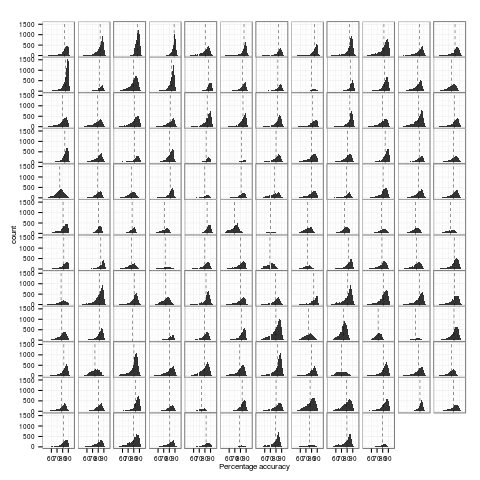

In [32]:
%%R
library(ggplot2)
library(grid)
library(plyr)
a=read.table("stats.txt", sep="\t", header=T)
a=subset(a, aln == 'ma')
a$perc = a$matches/(a$matches + a$insertions + a$deletions + a$mismatches)*100
cdat <- ddply(a, "sample", summarise, sample.mean=mean(perc))
cdat
groups=factor(a$sample)
ggplot(a, aes(x=perc)) +
  geom_histogram() +
  scale_x_continuous(breaks=c(60, 70, 80, 90)) +
  geom_vline(data=cdat, aes(xintercept=sample.mean), size=0.2, linetype="dashed") +
  theme_bw(base_size=8) + xlab("Percentage accuracy") +
  facet_wrap(~ sample) + theme(strip.text = element_blank(), strip.background = element_blank(), panel.margin.y = unit(-0.5, "lines"))
#ggsave("percs_144_ma.pdf", height=12, width=9)

